In [ ]:
import os
import argparse
import glob
import sys
from time import perf_counter
from pesq import pesq
from pymcd.mcd import Calculate_MCD

import pandas as pd
import librosa
import scipy
import numpy as np
from scipy.signal import lfilter
import soundfile as sf
from noisereduce import reduce_noise
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Audio, clear_output


def get_summary(project_folder):
    summary_file = os.path.join(project_folder, "evaluation/summary")
    if not os.path.isfile(summary_file):  
        print(summary_file, "not found")
        return 
    
    summary = pd.read_csv(summary_file, sep=' ', names=[
        "train_condition", "test_condition",
        "n_words", "n_words_correct",
        "n_sentence", "n_sentence_correct",
        "weighted", 
        "1", "2", "3", "4", "5", "6", "7"
    ])
    
    summary['test_snr'] = summary['test_condition'].str[-3:].astype(int)
    summary['train_snr'] = summary['train_condition'].str[-3:].astype(int)
    summary['fraction_sentence_correct'] = summary['n_sentence_correct']/summary['n_sentence']
    summary['fraction_word_correct'] = summary['n_words_correct']/summary['n_words']
    
    figure_table = pd.read_csv(os.path.join(project_folder, "figures/table.txt"), sep='\s+')
    return summary, figure_table

proj = sorted(os.listdir("../fade_projects"))
proj.insert(0, proj.pop(-1))
proj.insert(3, proj.pop(-2))
proj


['din_raw2',
 'din-bruce4',
 'din-ci-sr-0',
 'din-ci-sr-50',
 'din-ci-sr-100',
 'din-ci-sr-150',
 'din-ci-sr-200',
 'din-ci-sr-250',
 'din-ci-sr-300',
 'din-ci-sr-400',
 'din-ci-sr-500']

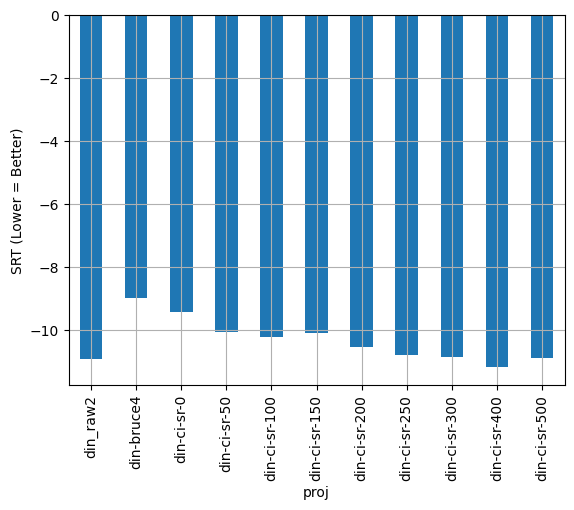

In [ ]:
figure_data = []
summ_data = []
for p in proj:
    path = os.path.join("../fade_projects", p)
    summ, figure_table = get_summary(path)
    figure_table['proj'] = p    
    figure_data.append(figure_table)
    summ['proj'] = p
    summ_data.append(summ)
    
    
figure_data = pd.concat(figure_data)
summ_data = pd.concat(summ_data)
figure_data.plot(kind='bar', x='proj', y='SRT')
plt.ylabel("SRT (Lower = Better)")
plt.legend().remove()
plt.grid();

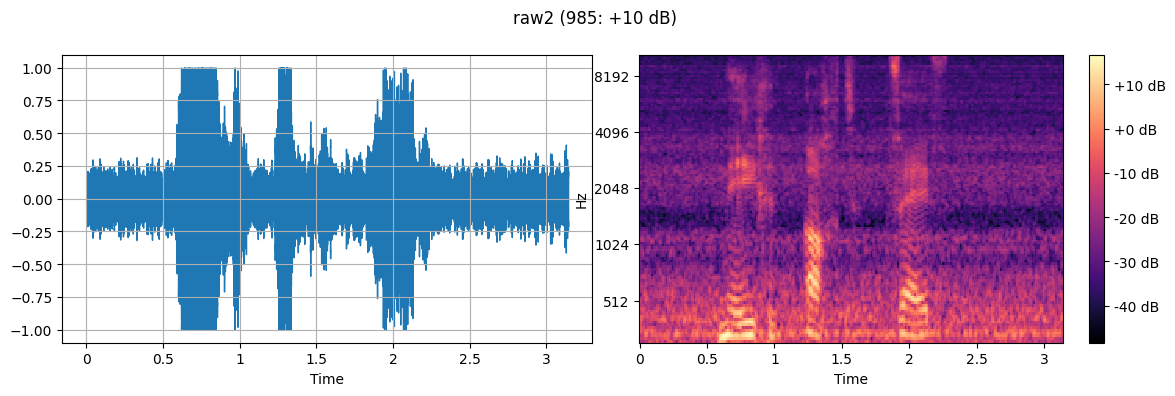

'------------------------------------------------------------------------------------------------------------------------------------------------------'

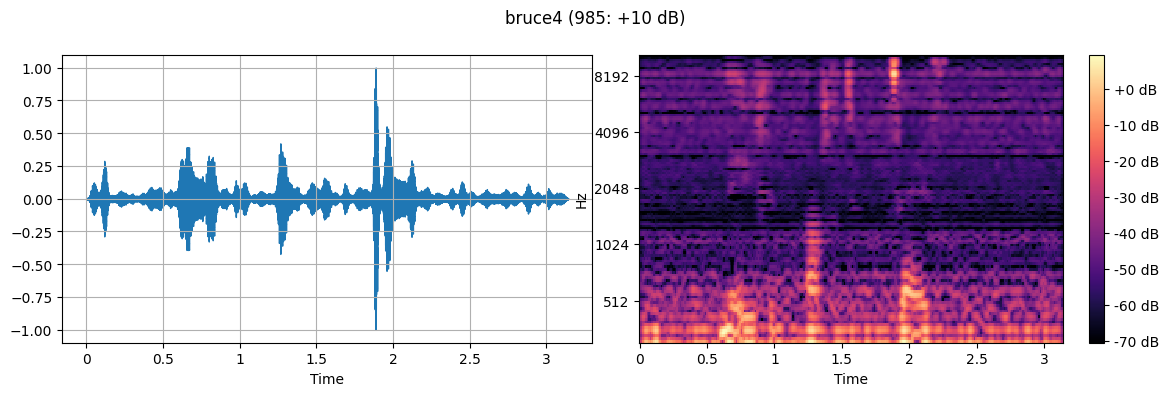

'------------------------------------------------------------------------------------------------------------------------------------------------------'

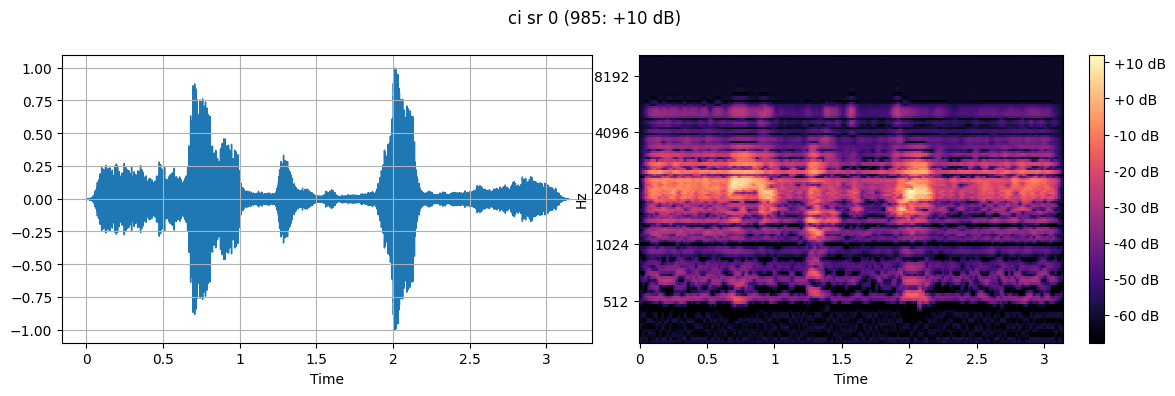

'------------------------------------------------------------------------------------------------------------------------------------------------------'

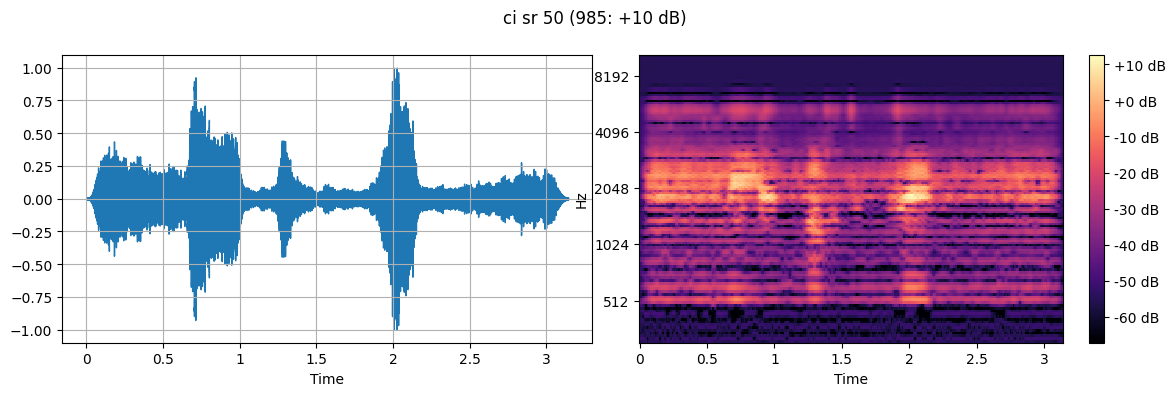

'------------------------------------------------------------------------------------------------------------------------------------------------------'

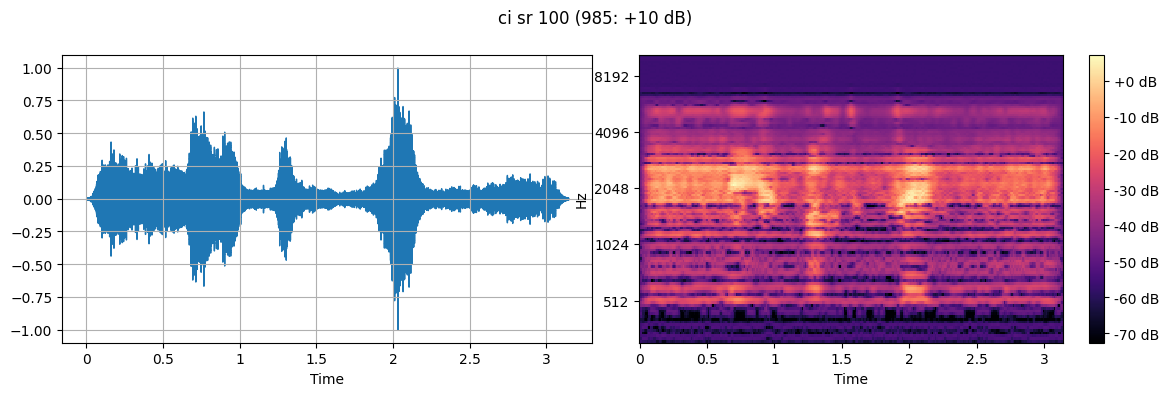

'------------------------------------------------------------------------------------------------------------------------------------------------------'

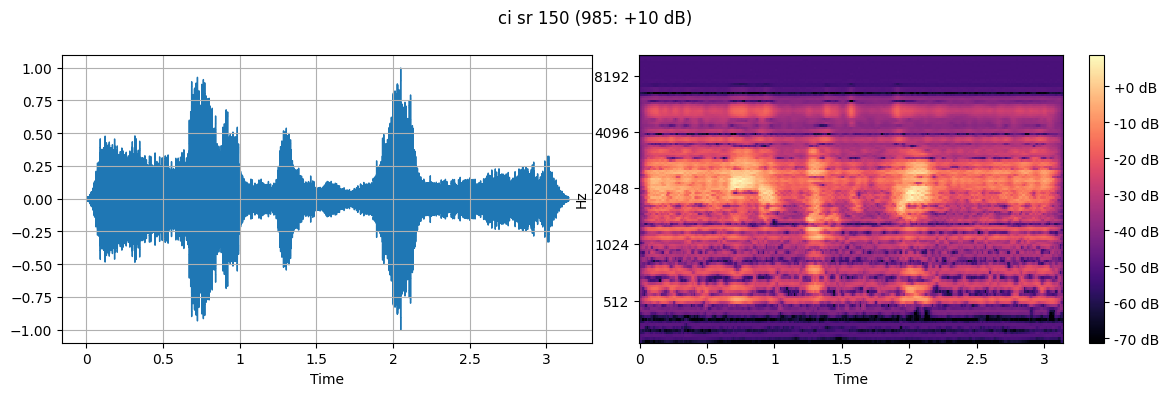

'------------------------------------------------------------------------------------------------------------------------------------------------------'

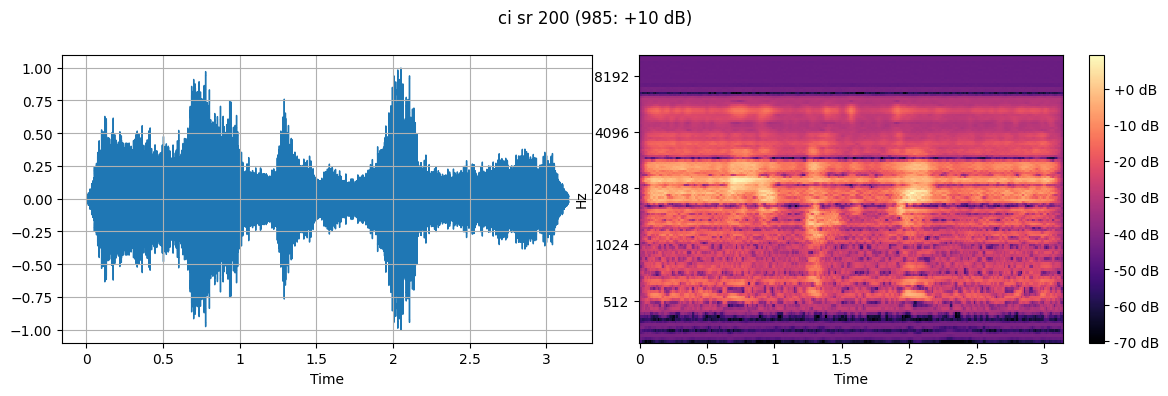

'------------------------------------------------------------------------------------------------------------------------------------------------------'

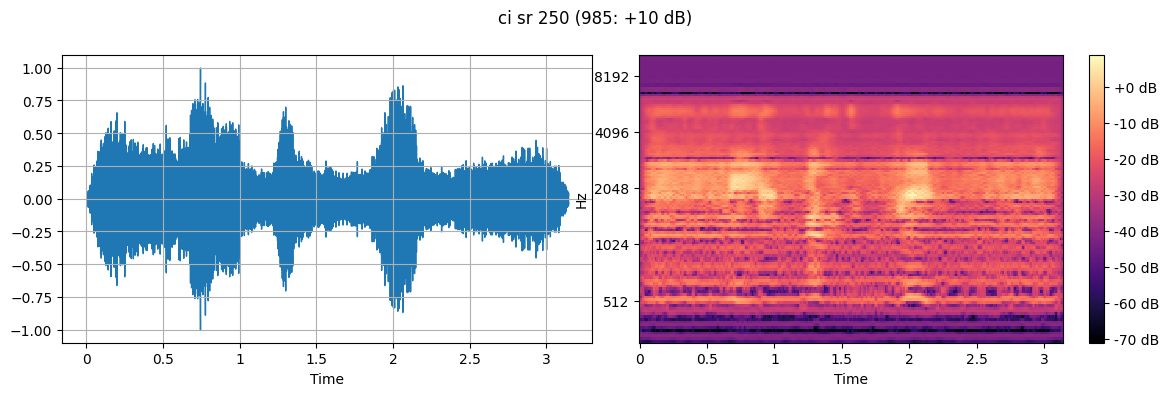

'------------------------------------------------------------------------------------------------------------------------------------------------------'

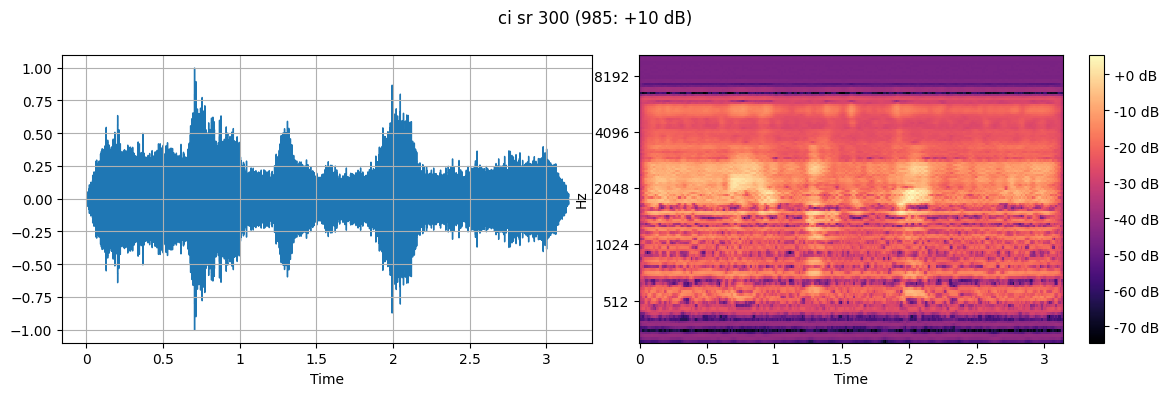

'------------------------------------------------------------------------------------------------------------------------------------------------------'

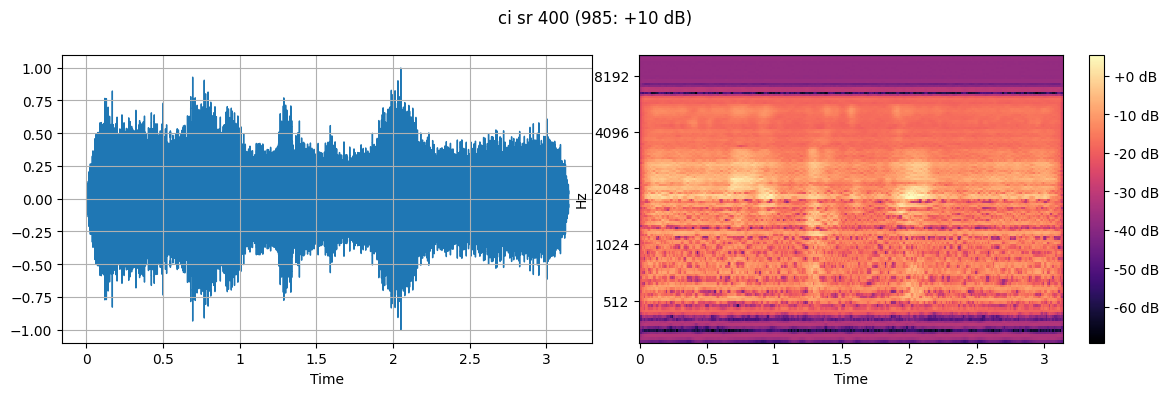

'------------------------------------------------------------------------------------------------------------------------------------------------------'

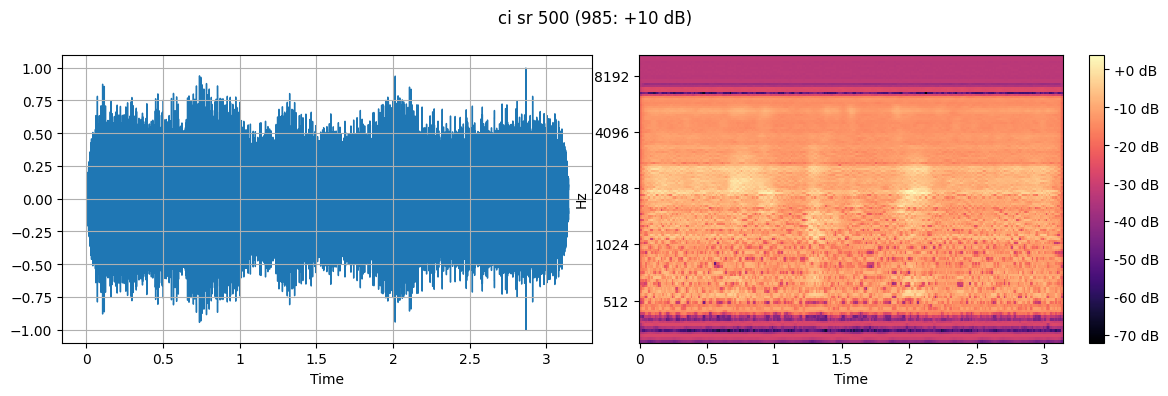

'------------------------------------------------------------------------------------------------------------------------------------------------------'

In [120]:
snr = 10
triplet = '985'
for p in proj:
    name = p.replace("_", " ").replace("-", " ").replace("din", "").strip()
    example = os.path.join("../fade_projects", p, f"corpus/test/tripletnoise/snr{snr:+03d}/rep00/{triplet}.wav")
    signal, fs = librosa.load(example, sr=None)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    librosa.display.waveshow(signal, sr=fs, ax=ax1)
    ax1.grid()
    f.suptitle(f"{name} ({triplet}: {snr:+d} dB)")
    plt.tight_layout()
    S = librosa.feature.melspectrogram(y=signal, sr=fs, n_mels=128, fmax=10_500, fmin=150)
    S_dB = librosa.power_to_db(S, ref=65.0)
    img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=fs, fmax=10_500, fmin=150, ax=ax2)
    
    f.colorbar(img, ax=ax2, format='%+2.0f dB')
    display(f)
    display(Audio(signal, rate=fs, normalize=False))
    display('-'*150)
    plt.close(f)

In [115]:


def compute_pesq(signal_ref, signal_pred, sr, band='wb'):
    target_sr = 16000
    ref = librosa.resample(signal_ref, orig_sr=sr, target_sr=target_sr)   # must be 16kHz
    deg = librosa.resample(signal_pred, orig_sr=sr, target_sr=target_sr)

    # Trim to same length
    min_len = min(len(ref), len(deg))
    ref = ref[:min_len]
    deg = deg[:min_len]
    try:
        score = pesq(target_sr, ref, deg, band)
    except:
        return -float("inf")
    return score

def compute_lsd(signal_ref, signal_pred, sr=22050, n_fft=512, hop_length=256):
    # Compute STFTs
    S_ref = np.abs(librosa.stft(signal_ref, n_fft=n_fft, hop_length=hop_length))
    S_pred = np.abs(librosa.stft(signal_pred, n_fft=n_fft, hop_length=hop_length))

    # Make sure they are the same shape
    min_frames = min(S_ref.shape[1], S_pred.shape[1])
    S_ref = S_ref[:, :min_frames]
    S_pred = S_pred[:, :min_frames]

    # Avoid log(0) by adding a small epsilon
    epsilon = 1e-10
    log_S_ref = 20 * np.log10(S_ref + epsilon)
    log_S_pred = 20 * np.log10(S_pred + epsilon)

    # Compute LSD per frame and average
    lsd = np.sqrt(np.mean((log_S_ref - log_S_pred)**2, axis=0))
    return np.mean(lsd)


mcd_toolbox = Calculate_MCD(MCD_mode="plain")

def calc_metrics(p, snr, triplet):
    true_wav =  os.path.join("../fade_projects", proj[0], f"corpus/test/tripletnoise/snr{snr:+03d}/rep00/{triplet}.wav")
    new_wav =  os.path.join("../fade_projects", p, f"corpus/test/tripletnoise/snr{snr:+03d}/rep00/{triplet}.wav")
    
    true_signal, fs = librosa.load(true_wav, sr=16000)
    signal, fs = librosa.load(new_wav, sr=16000)
    return (
        p, 
        snr, 
        triplet,
        compute_lsd(true_signal, signal, fs), 
        compute_pesq(true_signal, signal, fs, "wb"), 
        compute_pesq(true_signal, signal, fs, "nb"),
        mcd_toolbox.calculate_mcd(true_wav, new_wav)
    )
    


metrics = []
args = []
for snr in range(-20, 12, 2):
    base_true =  os.path.join("../fade_projects", proj[0], f"corpus/test/tripletnoise/snr{snr:+03d}/rep00/")
    for wav_file in os.listdir(base_true):
        true_wav = os.path.join(base_true, f"{wav_file}")
        triplet = wav_file.split(".wav")[0]
        for p in proj:
            args.append(
                (p, snr, triplet)
            )

from multiprocessing import Pool

with Pool(200) as p:
    metrics = p.starmap(calc_metrics, args)
    
'''
🎯 LSD Range (in dB):
    0.0–1.0 dB	Very close match (nearly identical)
    1.0–2.5 dB	Good match (small perceptual difference)
    2.5–5.0 dB	Noticeable difference
    5.0+ dB	Significant mismatch or distortion
    10+ dB	Large mismatch or error in input
PESQ Score Range:
    -0.5 to 4.5 for narrowband
    0.5 to 4.5 for wideband
    Higher = better quality (4.5 = excellent)
mcd: Perfect match (same signal): ~0.00 dB
    Good match: 1–5 dB
    Mild distortion: 6–10 dB
    High distortion: 10+ dB
'''

metrics = pd.DataFrame(metrics, columns="name, snr, triplet, lsd, pesq_wb, pesq_nb, mcd".split(", "))
metrics

name  snr triplet        lsd   pesq_wb   pesq_nb        mcd
0           din_raw2  -20     157   0.000000  4.643888  4.548638   0.000000
1         din-bruce4  -20     157  22.293859  1.034201  1.029635  17.159606
2        din-ci-sr-0  -20     157  32.921982  1.335755  3.207532  35.892008
3       din-ci-sr-50  -20     157  26.363317  1.067883  1.356118  33.878850
4      din-ci-sr-100  -20     157  25.916740  1.941651  3.075237  31.433682
...              ...  ...     ...        ...       ...       ...        ...
21115  din-ci-sr-200   10     451  22.230343  1.206620  2.247381  29.239177
21116  din-ci-sr-250   10     451  21.404928  1.227496  2.192366  28.935939
21117  din-ci-sr-300   10     451  22.405594  1.224784  1.839046  26.752615
21118  din-ci-sr-400   10     451  21.227354  1.230811  2.347327  27.368968
21119  din-ci-sr-500   10     451  22.422657  1.174817  1.554198  28.359062

[21120 rows x 7 columns]

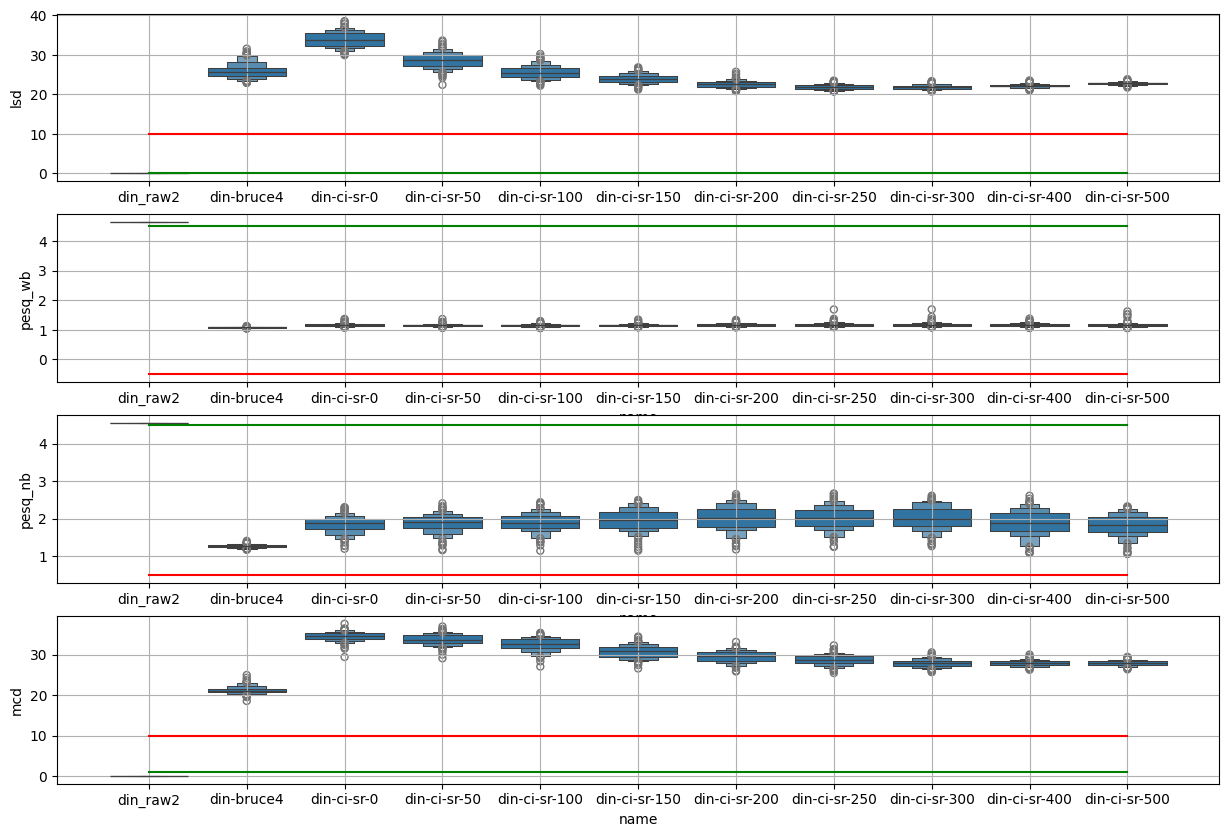

In [ ]:
import seaborn as sns
f, axes = plt.subplots(4, 1, figsize=(15, 10))


ranges = [
    (0, 10),
    (4.5, -.5,),
    (4.5, 0.5),
    (1, 10)
]
for i, label in enumerate(metrics.columns[3:]):
    sns.boxenplot(metrics[metrics.snr == 10], x='name', y=label, ax=axes[i], showfliers=True)
    axes[i].grid()  
    x = np.arange(len(proj))
    y = np.ones(len(proj))
    axes[i].plot(x, y*ranges[i][0], color='green')
    axes[i].plot(x, y*ranges[i][1], color='red')   
